<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/7_XGBoost/xgboost.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>

# XGBoost

In [1]:
!python -m pip install -U scikit-learn --upgrade # necesitamos sklearn >= 0.24

In [2]:
!python -m pip install xgboost

In [3]:
!python -m pip install lightgbm

In [4]:
!python -m pip install catboost

In [5]:
!python -m pip install sweetviz

In [6]:
!python -m pip install ipywidgets # puede ser necesario si lo corren local

In [7]:
!pip install scikit-optimize

## Introducción

Vamos a trabajar con un dataset famoso llamado **adult** tomado de UCI: https://archive.ics.uci.edu/ml/datasets/Adult . Son datos obtenidos del censo de Estados Unidos de 1994 y la tarea consiste en predecir si una persona gana más de 50.000 dólares al año o no. Por lo tanto, cada fila es una persona y las columnas son las características de la misma.

In [8]:
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/adult_train.csv")

In [10]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'target'],
      dtype='object')

In [11]:
df.shape

(32561, 15)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


- Las variables categóricas son: **workclass**, **education**, **marital-status**, **occupation**, **relationship**, **race**, **sex**, **native-country**.

- Las variables numéricas son: **age**, **fnlwgt**, **education-num**, **capital-gain**, **capital-loss**, **hours-per-week**

## Análisis exploratorio

Para este EDA vamos a usar un paquete que nos genera numerosos gráficos automáticamente y, por lo tanto, nos permite una aproximación rápida a los datos con los que vamos a trabajar.

In [13]:
# sweetviz es un paquete de análisis exploratorio automático, una alternativa también es pandas-profiling
import sweetviz as sv
#analyzing the dataset
advert_report = sv.analyze(df)

                                             |         | [  0%]   00:00 -> (? left)

El siguiente comando escribe un *html* con una serie de gráficos. Además, intenta abrir una pestaña nueva. Si ésto no sucede entonces deberán ejecutar manualmente el archivo. Para eso, si están en Google Colab deberán descargar el archivo y luego darle doble clic al archivo en su computadora.

In [14]:
advert_report.show_html('df.html')

Report df.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
[GFX1-]: glxtest: libEGL missing
[GFX1-]: glxtest: libEGL missing


Missing chrome or resource URL: resource://gre/modules/UpdateListener.jsm
Missing chrome or resource URL: resource://gre/modules/UpdateListener.jsm

###!!! [Parent][PImageBridgeParent] Error: RunMessage(msgname=PImageBridge::Msg_WillClose) Channel closing: too late to send/recv, messages will be lost



### Observaciones

Del reporte de *sweetviz* interesan destacar las siguientes cuestiones:


1- En **workclass** los nulos se identifican con **?**.

2- **target** está parejamente distribuido, con 76% para la categoría **<=50K** y 24% para **>50K**.

3- **capital-gain** y **capital-loss** son variables continuas pero mayoritariamente son 0 (91.7% y 95.3% respectivamente).

Cliqueando en ASSOCIATIONS (arriba al medio) podemos ver métricas de correlación entre variables, allí se observa que:

4- **education-num**, **capital-gain**, **hours-per-week**, **age**, **relationship** y en menor medida **marital-status** son las variables más correlacionadas con **target**.

## Preparamos train y test

In [15]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [16]:
X_train = df.drop("target",axis=1)
y_train = df["target"]

In [17]:
# LabelEncoder se usa para codificar las labels como números
l_encoder = LabelEncoder()

In [18]:
# Al hacer fit el objeto aprende un mapeo de cada label a un número que luego usaremos en test. 
# Al hacer transform ejecuta el mapeo. fit_transform primero ejecuta fit y luego transform
y_train = l_encoder.fit_transform(y_train)

In [19]:
test = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/adult_test.csv")

In [20]:
X_test = test.drop("target",axis=1)
y_test = test["target"]

In [21]:
l_encoder.transform(test["target"])

array([0, 0, 1, ..., 0, 0, 1])

In [22]:
# acá estamos traduciendo las etiquetas de las labels a números, con el mismo mapeo de antes (!!!!)
y_test = l_encoder.transform(y_test)

In [23]:
# inverse_transform nos permite hacer el mapeo en el sentido opuesto, de número a label
l_encoder.inverse_transform(y_test)

array(['<=50K', '<=50K', '>50K', ..., '<=50K', '<=50K', '>50K'],
      dtype=object)

In [24]:
# Para chequear que el mapeo se hace correctamente podemos hacer lo siguiente:

In [25]:
np.array_equal(test["target"].values, l_encoder.inverse_transform(y_test))

True

## Entreno modelos

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [27]:
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

In [28]:
import scipy.stats as st

In [29]:
from xgboost.sklearn import XGBClassifier

In [30]:
from lightgbm import LGBMClassifier

In [31]:
from catboost import CatBoostClassifier

In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
from sklearn.model_selection import RandomizedSearchCV

In [34]:
cat_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

num_columns = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

In [35]:
# vamos a usar polynomial features sobre las variables numéricas
poly = PolynomialFeatures()

In [36]:
# Las categorías "nuevas" que aparezcan se imputan con el valor de unknown_value
o_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99999999)

Los modelos que vamos a probar son XGBoost, LightGBM, CatBoost y Regresión logística.

Armamos un pipeline en donde:

1- Usamos `ColumnTransformer` para seleccionar las columnas numéricas y aplicar `PolynomialFeatures`. `remainder="passthrough"` hace que el resto de las columnas pasen sin cambios. De este paso vamos a optimizar el hiperparámetro que indica el grado del polinomio: `selector_num__poly__degree`.

2- Luego aplicamos una transformación sobre las variables categóricas. Para los modelos basados en árboles usamos `OrdinalEncoder` que codifica las categorías como números. De este paso vamos a optimizar el hiperparámetro que indica cómo se representan las categorías nuevas, no vistas en train, con `ord_encoder__unknown_value`. Por último, para la regresión logística aplicamos one hot encoding.

3- Finalmente aplicamos un clasificador.

Nota: los nombres de los hiperparámetros que vamos a optimizar se llaman como `nombre del step + __ + nombre del hiperparámetro`

In [37]:
pipeline = Pipeline([
    ("selector_num", ColumnTransformer([("poly", poly, num_columns)], remainder="passthrough")),
    ("cat_encoder", o_encoder),
    ("classifier", CatBoostClassifier())
    ])

In [38]:
pipeline.get_params()

{'memory': None,
 'steps': [('selector_num',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('poly', PolynomialFeatures(),
                                    ['age', 'fnlwgt', 'education-num',
                                     'capital-gain', 'capital-loss',
                                     'hours-per-week'])])),
  ('cat_encoder',
   OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999)),
  ('classifier', <catboost.core.CatBoostClassifier at 0x7f53ec098a00>)],
 'verbose': False,
 'selector_num': ColumnTransformer(remainder='passthrough',
                   transformers=[('poly', PolynomialFeatures(),
                                  ['age', 'fnlwgt', 'education-num',
                                   'capital-gain', 'capital-loss',
                                   'hours-per-week'])]),
 'cat_encoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999999),
 'classifier': <catboost.core.CatBoostClassi

In [39]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

In [40]:
# este diccionario de parámetros lo vamos a usar tanto para XGBoost como para LightGBM
params = {  
    "classifier__n_estimators": st.randint(20,150), # n. de árboles.
    "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
    "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
    "classifier__colsample_bytree": one_to_left, # ratio de la muestra de las columnas a la hora de construir el árbol
    "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
    'classifier__reg_alpha': st.uniform(0.05,10),   # término de regularización L1
    "classifier__min_child_weight": st.uniform(1,20), # Suma mínima del peso de la instancia (hessiano) requerida en los hijos
}

In [41]:
other_params = {"selector_num__poly__degree": [1, 2, 3],
                "cat_encoder__unknown_value": [np.nan, 99999999]}

Para optimizar modelos con distintos hiperparámetros se puede usar una lista de diccionarios, en donde cada diccionario es un hiperparámetro distinto. 

En primer lugar, classifier "pisa" el clasificador del pipeline original, en este caso `CatBoostClassifier`. 

En segundo lugar, pasamos los parámetros que definimos en `params` (usados en XGBoost y LightGBM) y `other_params` (que son los hiperparámetro que no corresponden al clasificador). 

En tercer lugar, también incluímos otros hiperparámetros de los clasificadores.

In [43]:
search_space = [{"classifier": [XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)], 
                 **params,
                 **other_params,
                "classifier__gamma": st.uniform(0, 10), # reducción mínima de la pérdida requerida para hacer un split
                },
                {"classifier": [LGBMClassifier(n_jobs=3, verbose=-1)],
                 **params,
                **other_params},
                {"classifier": [CatBoostClassifier(thread_count=3, verbose=False)],
                 **other_params,
                 "classifier__n_estimators": st.randint(20,150), # n. de árboles.
                "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
                "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
                "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
                },
               {
                   "classifier": [LogisticRegression(max_iter=1000)],
                   "classifier__C": [10**x for x in range(-5, 3)],
                   "cat_encoder": [OneHotEncoder(handle_unknown="ignore")],
               }]

In [46]:
model = RandomizedSearchCV(pipeline, search_space, n_iter=100, verbose=1, cv=3,n_jobs=-1)

Comenzamos el entrenamiento

In [47]:
model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bombi/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('selector_num',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('poly',
                                                                               PolynomialFeatures(),
                                                                               ['age',
                                                                                'fnlwgt',
                                                                                'education-num',
                                                                                'capital-gain',
                                                                                'capital-loss',
                                                                                'hours-per-week'])])),
                                             ('cat_encoder',
                                              OrdinalEncoder(handle_unknown='use_encoded_value',
                                                             unknown_value=99999999)),
                                             ('classifier',
                                              <catboost.c...
                                         'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5409c3d6a0>,
                                         'classifier__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f53ec0984f0>,
                                         'selector_num__poly__degree': [1, 2,
                                                                        3]},
                                        {'cat_encoder': [OneHotEncoder(handle_unknown='ignore')],
                                         'classifier': [LogisticRegression(max_iter=1000)],
                                         'classifier__C': [1e-05, 0.0001, 0.001,
                                                           0.01, 0.1, 1, 10,
                                                           100]}],
                   verbose=1)

Guardamos los resultados

In [48]:
results = pd.DataFrame(model.cv_results_)

In [49]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_cat_encoder__unknown_value', 'param_classifier',
       'param_classifier__learning_rate', 'param_classifier__max_depth',
       'param_classifier__n_estimators', 'param_classifier__subsample',
       'param_selector_num__poly__degree', 'param_cat_encoder',
       'param_classifier__C', 'param_classifier__colsample_bytree',
       'param_classifier__min_child_weight', 'param_classifier__reg_alpha',
       'param_classifier__gamma', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [50]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cat_encoder__unknown_value,param_classifier,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__subsample,...,param_classifier__min_child_weight,param_classifier__reg_alpha,param_classifier__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,8.044122,0.064549,2.617906,0.046708,99999999,<catboost.core.CatBoostClassifier object at 0x...,0.226477,3,137,0.906955,...,NaN,NaN,NaN,"{'cat_encoder__unknown_value': 99999999, 'clas...",0.848904,0.853879,0.865383,0.856055,0.006901,72
1,1.671219,0.581309,0.670228,0.121023,NaN,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,{'cat_encoder': OneHotEncoder(handle_unknown='...,0.759167,0.759167,0.759237,0.759190,0.000033,95
2,3.555089,0.229612,0.648136,0.044169,99999999,<catboost.core.CatBoostClassifier object at 0x...,0.156049,5,148,0.943488,...,NaN,NaN,NaN,"{'cat_encoder__unknown_value': 99999999, 'clas...",0.858577,0.863368,0.866489,0.862811,0.003254,42
3,18.804418,0.193105,3.118723,0.355800,NaN,<catboost.core.CatBoostClassifier object at 0x...,0.19675,8,136,0.811845,...,NaN,NaN,NaN,"{'cat_encoder__unknown_value': nan, 'classifie...",0.846877,0.850746,0.850364,0.849329,0.001741,85
4,32.949298,0.528416,0.839128,0.152989,NaN,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,{'cat_encoder': OneHotEncoder(handle_unknown='...,0.857103,0.859683,0.862526,0.859771,0.002215,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.661024,0.268447,0.849565,0.024554,NaN,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,{'cat_encoder': OneHotEncoder(handle_unknown='...,0.847890,0.851391,0.852944,0.850742,0.002114,79
96,5.453895,0.527338,0.971436,0.055309,99999999,<catboost.core.CatBoostClassifier object at 0x...,0.386762,9,49,0.799515,...,NaN,NaN,NaN,"{'cat_encoder__unknown_value': 99999999, 'clas...",0.842178,0.852865,0.851285,0.848776,0.004710,86
97,2.703891,0.378441,0.799639,0.107322,NaN,LogisticRegression(max_iter=1000),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,{'cat_encoder': OneHotEncoder(handle_unknown='...,0.847890,0.851391,0.852944,0.850742,0.002114,79
98,3.433689,0.166108,0.939719,0.109934,NaN,<catboost.core.CatBoostClassifier object at 0x...,0.387037,7,69,0.980937,...,NaN,NaN,NaN,"{'cat_encoder__unknown_value': nan, 'classifie...",0.848904,0.855445,0.858564,0.854304,0.004026,77


El mejor modelo es...

In [51]:
model.best_estimator_

Pipeline(steps=[('selector_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('cat_encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f53bb3e5820>)])

Para a dibujar la curva ROC, para eso primero usamos `predict_proba` y luego importamos `plot_roc` de `scikitplot`.

In [54]:
model.best_score_

0.8684316580183081

In [55]:
y_predicted = model.predict_proba(X_test)

In [56]:
!pip install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [57]:
from scikitplot.metrics import plot_roc

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

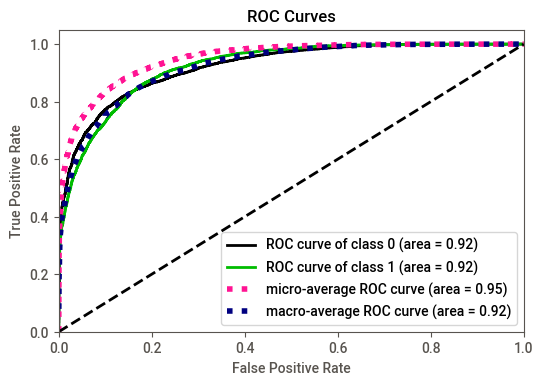

In [63]:
plot_roc(y_test, y_predicted)

In [64]:
from sklearn.metrics import roc_auc_score

In [65]:
roc_auc_score(y_test, y_predicted[:,1])

0.9221366602955232

## Uso CatBoost con categorical features

In [66]:
categorical_features_indices = np.where(X_train.dtypes == object)[0]

In [67]:
model = CatBoostClassifier(
    random_seed=42,
    logging_level='Silent'
)

In [68]:
from catboost import Pool, metrics, cv

cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(X_train, y_train, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [69]:
# obtengo la mejor epoch
cv_data["test-Logloss-mean"].argmin()

998

In [70]:
# vamos a reentrenar con 811 steps

In [81]:
model = CatBoostClassifier(
    iterations=998,
    random_seed=42,
    logging_level='Silent',
    cat_features=categorical_features_indices
)

In [82]:
model.fit(X_train, y_train)

In [83]:
predictions_probs = model.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

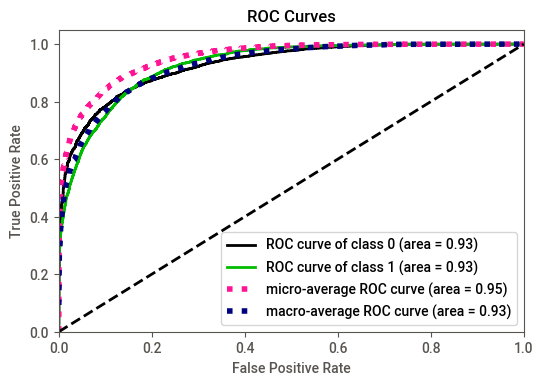

In [84]:
plot_roc(y_test, predictions_probs)

In [85]:
roc_auc_score(y_test, predictions_probs[:,1])

0.9280646046911436

In [86]:
model.score(X_test,y_test)

0.8735949880228487